# Description
The goals of this notebook are to create one comprehensive dataframe holding all corpora (including with removed punct), and generate samples for language modelling.

# Imports and Settings

In [1]:
import pandas as pd
import numpy as np
import string
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from lexicalrichness import LexicalRichness

In [2]:
from formutils import *
from ddp_util import *

In [3]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [4]:
plt.style.use(["bmh", "plot.mplstyle"])
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Prepare corpora

In [5]:
df_main = pd.read_json("../data-push/0c-preprocessing-norm/df-processed-final-full-texts.json", encoding="utf-8")
df_ref = pd.read_json("../data-push/0c-preprocessing-norm/df-ref-processed-final.json", encoding="utf-8")

# Create comprehensive corpus as dataframe

Counts values, ditch low representations

In [6]:
df_ref.category.value_counts()

Prayer             74
Miscellaneous      55
Biblical poetry    49
Legend             43
Sermon             33
Didactic poetry    32
Epic               25
Translation        22
Recipe             13
Rhyme               4
Name: category, dtype: int64

In [7]:
df_ref = df_ref[~(df_ref["category"] == "Rhyme")]

In [8]:
df_ref.category.value_counts()

Prayer             74
Miscellaneous      55
Biblical poetry    49
Legend             43
Sermon             33
Didactic poetry    32
Epic               25
Translation        22
Recipe             13
Name: category, dtype: int64

Reorganize dataframe columns and names

In [9]:
df_main.columns = ["id", "abstract", "text", "year"]
df_main["type"] = "main"
df_main["category"] = "Charter"
df_ref["type"] = "ref"
df_ref["year"] = None
df_ref["abstract"] = None

Merge frames and set new id, drop texts without categories

In [10]:
df_merged = pd.concat([df_main,df_ref])
df_merged["id_old"] = df_merged["id"]

df_merged = df_merged[~df_merged.category.isna()]

In [11]:
df_merged["id"] = df_merged["id_old"].apply(lambda x: to_md5(x))
id_dict = df_merged.set_index("id")["id_old"].to_dict()

with open("../data-push/0d-sampling/id-mapping.json", "w") as f:
    json.dump(id_dict, f)

Generate nopunct version

In [12]:
df_merged_nopunct = df_merged.copy()
df_merged_nopunct["text"] = df_merged_nopunct["text"].apply(
    lambda x: x.translate(str.maketrans("", "", string.punctuation))
)

Generate types, tokens, and word length for all corpora --- This differentiation is done since previously removed punctuation affects length count, although not tokens and types, given they are removed from the module LexicalRichness.

Calculate text measures for main corpus

In [13]:
lexical_richness = df_merged["text"].apply(LexicalRichness)
df_merged["tokens"] = lexical_richness.apply(lambda x: x.words)
df_merged["types"] = lexical_richness.apply(lambda x: x.terms)
df_merged["length"] = df_merged["text"].apply(lambda x: len(x))

For corpus without punctuation

In [14]:
lexical_richness = df_merged_nopunct["text"].apply(LexicalRichness)
df_merged_nopunct["tokens"] = lexical_richness.apply(lambda x: x.words)
df_merged_nopunct["types"] = lexical_richness.apply(lambda x: x.terms)
df_merged_nopunct["length"] = df_merged_nopunct["text"].apply(lambda x: len(x))

Show lengths

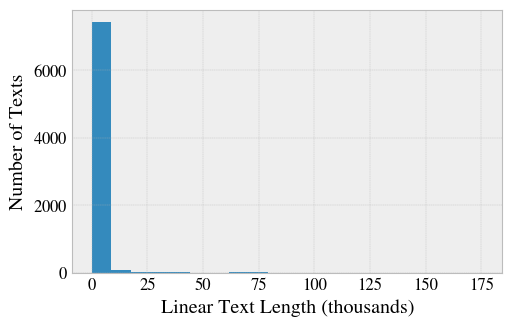

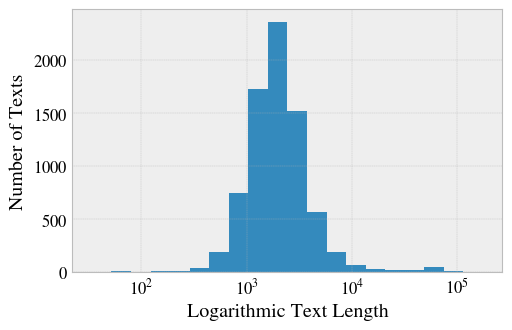

In [22]:
length = pd.Series(df_merged.length)

_, bins = np.histogram(length, bins=20)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))

plt.figure()
plt.hist(length, bins=bins, color=colors[0])
plt.xlabel("Linear Text Length (thousands)")
plt.ylabel("Number of Texts")
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x/1000:.0f}"))

plt.figure()
plt.hist(length, bins=logbins, color=colors[0])
plt.xscale("log")
plt.xlabel("Logarithmic Text Length")
plt.ylabel("Number of Texts")
plt.savefig("../data-push/0d-sampling/text-lengths-outliers.pdf", format="pdf", bbox_inches="tight")

plt.show()

Show inliers

In [16]:
df_inliers = filter_df_by_iqr(df_merged, "length")
df_inliers.category.value_counts()

Charter            6920
Prayer               62
Miscellaneous        24
Biblical poetry      23
Didactic poetry      14
Legend               13
Recipe                9
Sermon                9
Translation           8
Epic                  4
Name: category, dtype: int64

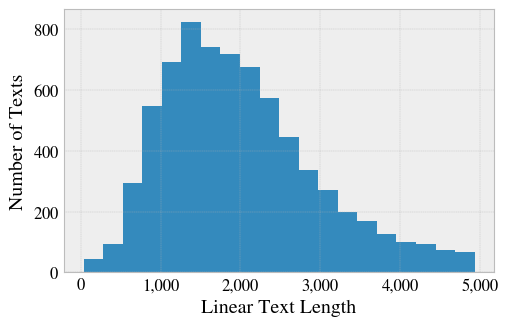

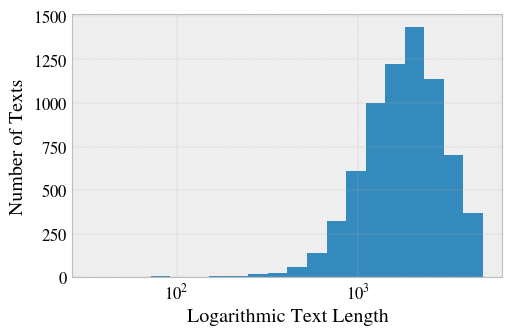

In [23]:
length = pd.Series(df_inliers.length)

_, bins = np.histogram(length, bins=20)
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))

plt.figure()
plt.hist(length, bins=bins, color=colors[0])
plt.xlabel("Linear Text Length")
plt.ylabel("Number of Texts")
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
plt.savefig("../data-push/0d-sampling/text-lengths-inliers.pdf", format="pdf", bbox_inches="tight")

plt.figure()
plt.hist(length, bins=logbins, color=colors[0])
plt.xscale("log")
plt.xlabel("Logarithmic Text Length")
plt.ylabel("Number of Texts")

plt.show()

# Exports

Export merged data set, i.e., charters and reference corpus

In [18]:
df_merged_text = df_merged[df_merged["type"] == "main"].set_index("id")["text"]

In [19]:
df_merged.to_json("../data-push/0d-sampling/df-merged.json")

## Create and export training and validation (sample) data set of main corpus
Using dict-method used for individual JSON objects in JSON file, as preferred by transformers library

In [20]:
train_data, val_data = train_test_split(df_merged_text, test_size=0.2, random_state=23)

with open(f"../data-push/0d-sampling/train-validate/charters-main-train-data.json", "w") as f:
    for _, item in train_data.items():
        item_dict = {"text": item}
        json.dump(item_dict, f)
        f.write("\n")

with open(f"../data-push/0d-sampling/train-validate/charters-main-SAMPLE-train-data.json", "w") as f:
    for _, item in train_data.sample(n=100).items():
        item_dict = {"text": item}
        json.dump(item_dict, f)
        f.write("\n")


with open(f"../data-push/0d-sampling/train-validate/charters-main-val-data.json", "w") as f:
    for _, item in val_data.items():
        item_dict = {"text": item}
        json.dump(item_dict, f)
        f.write("\n")

with open(f"../data-push/0d-sampling/train-validate/charters-main-SAMPLE-val-data.json", "w") as f:
    for _, item in val_data.sample(n=20).items():
        item_dict = {"text": item}
        json.dump(item_dict, f)
        f.write("\n")

## Create and export optional whole data set without punctuation
This is then used for identifying formulaic sequences and flexibility.

In [21]:
df_merged_nopunct.to_json("../data-push/0d-sampling/df-merged-nopunct.json")